In [1]:
import sys, os, datetime
sys.path.append("../../../")

from utils.contract_utils import init_contract
from utils.network_utils import configure_network_and_connect

import brownie

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
configure_network_and_connect(
    node_provider_https=f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}",
    network_name='mainnet'
)

In [4]:
pools = {
    "ankreth": "0xA96A65c051bF88B4095Ee1f2451C2A9d43F53Ae2",
    "reth": "0xF9440930043eb3997fc70e1339dBb11F341de7A8",
    "alusd": "0x43b4FdFD4Ff969587185cDB6f0BD875c5Fc83f8c",
    "frax": "0xd632f22692FaC7611d2AA1C0D552930D43CAEd3B",
}

In [5]:
block_number_start = 13022595 # much before votium began.

In [10]:
def get_token_balances_from_block(
    block_number_start: int,
    pool_contract: brownie.Contract, 
    block_steps: int = 10000
) -> pd.DataFrame:

    current_block = brownie.web3.eth.block_number
    blocks_to_calculate = list(range(block_number_start, current_block, block_steps))
    blocks_to_calculate.append(current_block)

    data = {'timestamp': [], 'block_number': [], 'total_coin_balances': []}

    for block_number in blocks_to_calculate:

        block_details = brownie.web3.eth.get_block(block_number)
        block_time = datetime.datetime.fromtimestamp(block_details['timestamp'])

        try:
            pool_balances = pool_contract.get_balances(block_identifier=block_number)
        except ValueError:
            continue
        except:  # old vyper contracts did not have get_balances method
            pool_balances = []
            for coin_index in range(10):
                try:
                    pool_balance_coin = pool_contract.balances(coin_index, block_identifier=block_number)
                    pool_balances.append(pool_balance_coin)
                except ValueError:
                    break

        total_coins = sum(pool_balances)

        data['timestamp'].append(block_time)
        data['block_number'].append(block_number)
        data['total_coin_balances'].append(total_coins)

    df_data = pd.DataFrame(data)

    return df_data.set_index('timestamp')


In [29]:
dict_data_pools = {}
for pool_name, pool_addr in pools.items():

    pool_contract_obj = init_contract(pool_addr)

    dict_data_pools[pool_name] = get_token_balances_from_block(
        block_number_start=block_number_start,
        pool_contract=pool_contract_obj,
        block_steps=10000
    )
dict_data_pools

{'ankreth':                      block_number      total_coin_balances
 timestamp                                                 
 2021-08-14 15:32:40      13022595  17490197174311204967621
 2021-08-16 04:23:08      13032595  17381557506492225060242
 2021-08-17 17:30:51      13042595  17376056549214780636935
 2021-08-19 06:37:28      13052595  17263852413365474213824
 2021-08-20 19:42:22      13062595  17193485372573283866313
 2021-08-22 08:39:05      13072595  16211467384583697489513
 2021-08-23 21:50:55      13082595  16210461642962976074390
 2021-08-25 10:47:25      13092595  16225211419924102399442
 2021-08-26 23:48:42      13102595  16225611008308912769106
 2021-08-28 13:13:09      13112595  16187406372213022125303
 2021-08-30 02:12:47      13122595  16187864950532162476527
 2021-08-31 15:16:23      13132595  16187980850247113262304
 2021-09-02 04:27:38      13142595  16187980850247113262304
 2021-09-03 17:26:34      13152595  16174023048982102731396
 2021-09-05 06:26:35      131

In [14]:
bribe_tx = pd.Timestamp("2021-09-19 19:41:48", tz="utc")
bribe_tx

Timestamp('2021-09-19 19:41:48+0000', tz='UTC')

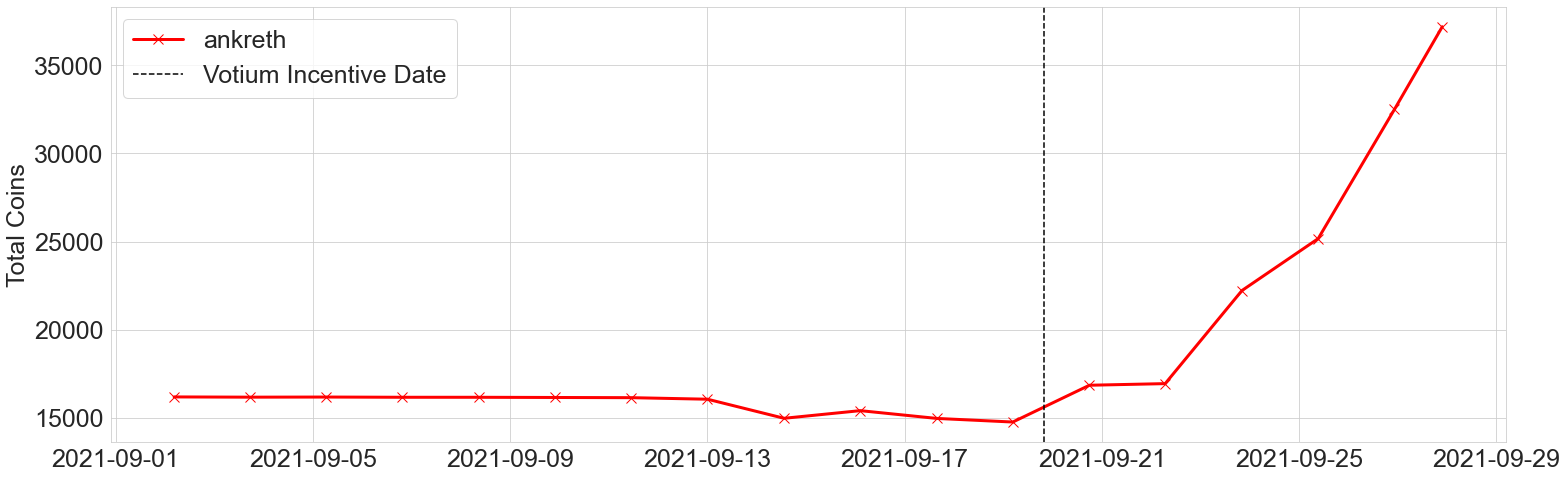

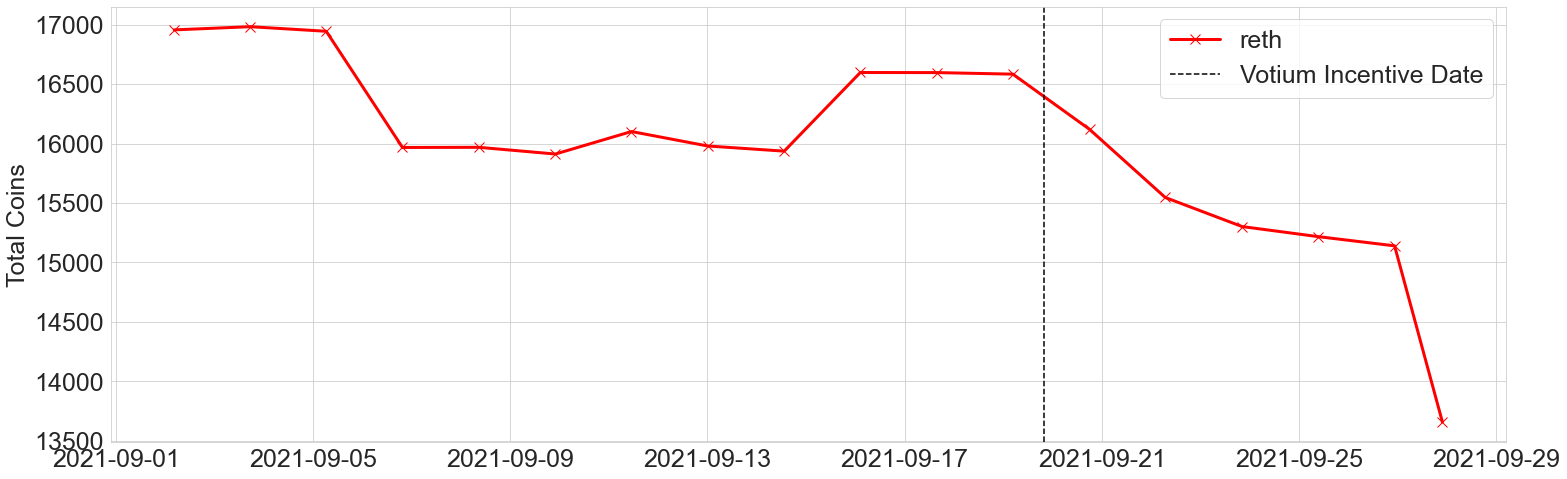

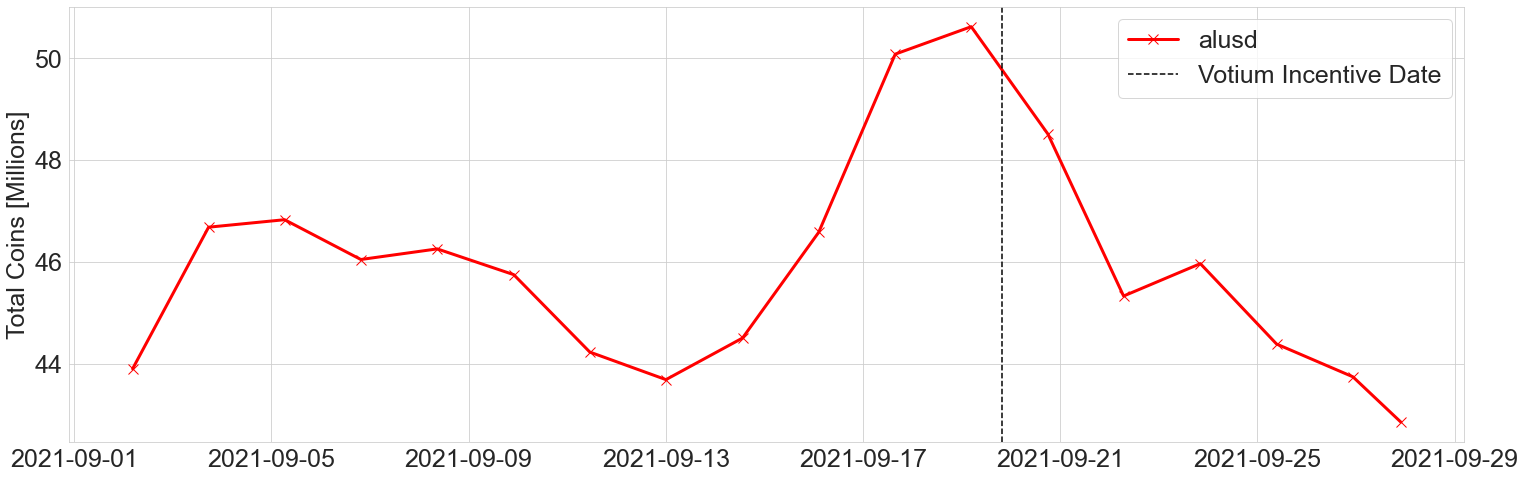

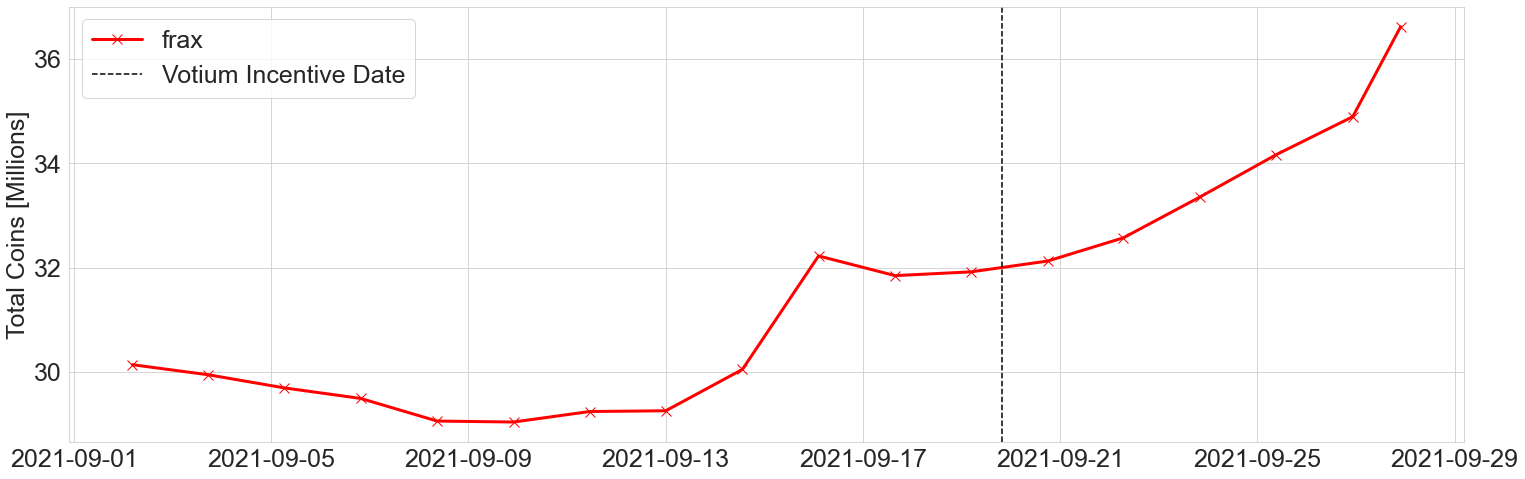

In [28]:
for pool_name, df_pool_tvl in dict_data_pools.items():

    fig, ax = plt.subplots(1,1, figsize=(25, 8))

    plot_start_date = pd.Timestamp("2021-09-01")
    df_plot = df_pool_tvl[df_pool_tvl.index > plot_start_date]
    df_plot.reset_index(inplace=True)

    decimals = 1e-18
    millionth_decimal = False
    if (df_plot.total_coin_balances * 1e-18).mean() > 1e8:
        decimals *= 1e-7
        millionth_decimal = True

    ax.plot(df_plot.timestamp, df_plot.total_coin_balances * decimals, marker='x', color='r', lw=3, ms=10, label=pool_name)
    ax.axvline(x=bribe_tx, label="Votium Incentive Date", color='k', ls='--')

    ax.set_ylabel("")
    if not millionth_decimal:
        ax.set_ylabel("Total Coins", fontsize=25)
    else:
        ax.set_ylabel("Total Coins [Millions]", fontsize=25)
    # ax.set_title(f"Pool {coin_0} / {coin_1} pool\n{peg_ratio_explanation}", fontsize=25);
    ax.tick_params(axis='both', which='major', labelsize=25);

    ax.legend(fontsize=25);
    try:

        ax.ticklabel_format(useOffset=False, style='plain');
    
    except AttributeError:

        continue